# Compensation factor measurement

In [235]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [236]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os.path as op
from pprint import pprint as pp
import scipy.stats
import seaborn as sns
import copy

In [237]:
datapath = "~/teigen_data/output_rows.csv"

In [238]:
plotkw ={
    "figsize": [9, 6], 
    # "fontsize": 14
    # "linestyle": "-",
    # "marker": "x"
}

In [239]:
# scripts can be runned
# %run run_experiments.ipynb

In [240]:

df = pd.read_csv(op.expanduser(datapath))
# remove duplicates
ks = copy.copy(list(df.keys()))
ks.remove("datetime")
df = df.drop_duplicates(ks)

df = df.drop_duplicates()
df["surface error [mm^2]"] = df["numeric surface [mm^2]"] - df["surface [mm^2]"]
df["surface error [%]"] = df["surface error [mm^2]"] / df["surface [mm^2]"] * 100
df["volume error [mm^3]"] = df["numeric volume [mm^3]"] - df["volume [mm^3]"]
df["volume error [%]"] = df["volume error [mm^3]"] / df["volume [mm^3]"] * 100
df["measurement_resolution"] = df["postprocessing measurement_resolution"]
df["length_distribution_mean"] = df["generators Unconnected tubes length_distribution_mean"]
df["radius_distribution_mean"] = df["generators Unconnected tubes radius_distribution_mean"]

In [241]:
def show_radius(dfs, x_key="measurement_resolution"):
    dfsp = dfs[["radius_volume_estimation_numeric", "radius_surface_estimation_numeric", x_key]].sort_values(
        x_key).sort_values(x_key)
    
    if len(dfsp) < 1:
        return dfsp
    # fig = plt.figure(figsize=[25, 18])
    ax = plt.subplot(111)
    dfsp.plot(
        ax=ax, x=x_key, **plotkw)
    # ax = plt.subplot(122)
    # dfsp[["volume error [%]"]].plot(
    #     ax=ax, kind="box", **plotkw)
    plt.suptitle(radius_method + " ({})".format(len(dfs)))
    return dfsp

def show_error(dfs, x_key="measurement_resolution"):
    
    dfsp = dfs[["surface error [%]", "volume error [%]", 
                x_key]].sort_values(x_key)

    if len(dfsp) < 1:
        return dfsp
    # wilcoxon - čím větší, tím lepší, alespoň 0.05
    surf_w = scipy.stats.wilcoxon(x=dfs["surface [mm^2]"], y=dfs["numeric surface [mm^2]"], correction=False, zero_method="pratt")
    # spearman čím menší, tím lepší
    surf_s = scipy.stats.spearmanr(dfs["surface [mm^2]"], dfs["numeric surface [mm^2]"])
    
    # wilcoxon - čím větší, tím lepší
    vol_w = scipy.stats.wilcoxon(x=dfs["volume [mm^3]"], y=dfs["numeric volume [mm^3]"], correction=False, zero_method="pratt")
    # spearman čím menší, tím lepší
    vol_s = scipy.stats.spearmanr(dfs["volume [mm^3]"], dfs["numeric volume [mm^3]"])
    
    print radius_method, ": \nsurface (w/s): \n" , surf_w,"\n", surf_s, "\nvolume (w/s): \n", vol_w, "\n",vol_s

    fig = plt.figure(figsize=[25, 18])
    ax = plt.subplot(131)
    dfsp.plot(
        ax=ax, x=x_key, **plotkw)
    ax = plt.subplot(132)
    dfsp[["volume error [%]"]].plot(
        ax=ax, kind="box", **plotkw)
    ax = plt.subplot(133)
    dfsp[["surface error [%]"]].plot(
        ax=ax, kind="box", **plotkw)
    plt.suptitle(radius_method)
    return dfsp

# Estimate radius from volume and surface


$$ r_0 r_c = \frac{1}{2} \sqrt{\frac{S}{\pi}}$$ 
$$ r_0 r_c = \sqrt[3]{\frac{3 V}{4 \pi}}$$ 

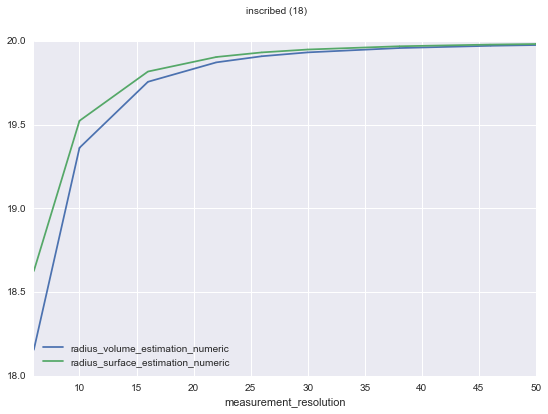

In [242]:
df["radius_volume_estimation_numeric"] = ((3 * df["numeric volume [mm^3]"] / (4* np.pi))**(1.0/3.0))
df["radius_volume_estimation"] = ((3 * df["volume [mm^3]"] / (4* np.pi))**(1.0/3.0))
df["radius_surface_estimation_numeric"] = ((df["numeric surface [mm^2]"] / (4 * np.pi))**(.5))
df["radius_surface_estimation"] = ((df["surface [mm^2]"] / (4* np.pi))**(.5))
for radius_method in [
    "inscribed", 
    # "circumscribed", "cylinder surface", "cylinder volume", "average" 
]:
        
    dfs = df[
        df["output note"] == "compensation method 1 sphere " + radius_method
        # df["generators Unconnected cylinders radius_distribution_mean"] == 5 
    ]
    show_radius(dfs)
    


## Volume interpolation

Calculate `x` and `y` coefficients and copy it into `tb_vtk.py` file in

    ...
    elif polygon_radius_selection_method == "cylinder volume + sphere compensation":
        x = [ ... ]
        y = [ ... ]

x = [6, 10, 16, 22, 26, 30, 38, 46, 50, 100, 200, ]
y = [0.907761049371, 0.968085929825, 0.987801059217, 0.993609867914, 0.995442808677, 0.996586891474, 0.997881035346, 0.998557648546, 0.998780366693, 1.0, 1.0, ]


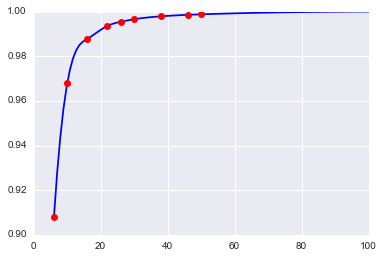

In [243]:
from scipy.interpolate import UnivariateSpline
from scipy.interpolate import InterpolatedUnivariateSpline

radius_method = "inscribed"
dfs = df[
    df["output note"] == "compensation method 1 sphere " + radius_method
]
if len(dfs) > 0:
    dfsm = dfs.groupby("measurement_resolution").mean().reset_index()

    x = list(dfsm["measurement_resolution"])
    y = list(dfsm["radius_volume_estimation_numeric"] / dfsm["radius_volume_estimation"])

    x.append(100)
    y.append(1.0)

    x.append(200)
    y.append(1.0)

    x = np.asarray(x)
    y = np.asarray(y)
    spl1 = InterpolatedUnivariateSpline(x, y)
    # spl1 = UnivariateSpline(x, y,k=5)
    # spl1.set_smoothing_factor(0.1)
    xs = np.linspace(6, 100, 100)

    plt.plot(
        xs[:], spl1(xs[:]), "b" , 
        x[:-2], y[:-2], "ro", 
    )
    stx = "x = ["
    for i in x:
        stx = stx + str(i) + ", "
    stx += "]"
    sty = "y = ["
    for i in y:
        sty = sty + str(i) + ", "
    sty += "]"
    print stx
    print sty


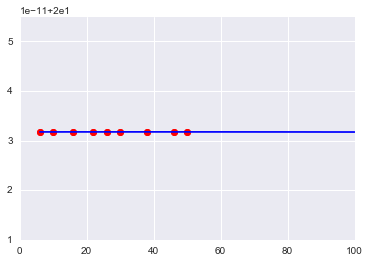

In [244]:
import scipy
import copy
if len(dfs) > 1:
    # f = scipy.interpolate.interp1d(x,y, kind="quadratic", fill_value="extrapolate")
    x = np.asarray(list(dfs["measurement_resolution"]))
    y = np.asarray(list(dfs["radius_volume_estimation"]))

    z = np.polyfit(x,y, 2)
    f = np.poly1d(z)
    plt.plot(x, y, "ro")
    plt.plot(xs, f(xs), "b")
    plt.show()

[  2.00000001e+01   1.22927396e-10   1.00000000e+00   1.00000000e+00
   1.00000000e+00   1.00000000e+00]


/Users/mjirik/miniconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: overflow encountered in exp


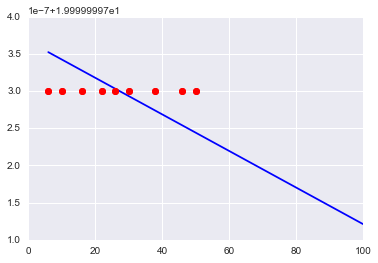

In [245]:
from scipy.optimize import curve_fit
    
def func(x, a, b, c, e, f, g):
    return a*np.exp(-b * x) # + # c + np.sin(e*x + f) * np.exp(g*x)



def func1(x, theta, omega0, K):
    jmt = (1 - theta**2)**0.5
    out = K * (1 - 1/jmt * np.exp(-1 * theta * omega0 * x))
    # out = K * (1 - (1 / jmt * np.exp(-1 * theta * omega0 * x)) * np.sin(omega0 * jmt * x)) 
    #+ np.arccos(theta))
    return out

if len(dfs) > 1:
    x = np.asarray(list(dfs["measurement_resolution"]))
    y = np.asarray(list(dfs["radius_volume_estimation"]))

    popt, pcov = curve_fit(func, x, y, bounds=(-np.inf, np.inf))
    print popt

    plt.plot(xs, func(xs, *popt), "b")
    plt.plot(x, y, "ro")
    plt.show()

## Surface

In [246]:

radius_method = "cylinder surface"
dfs = df[
    df["output note"] == "compensation method 1 sphere " + radius_method
]
dfsm = dfs.groupby("measurement_resolution").mean().reset_index()

show_radius(dfsm)


,radius_volume_estimation_numeric,radius_surface_estimation_numeric,measurement_resolution


In [247]:
from scipy.interpolate import UnivariateSpline
from scipy.interpolate import InterpolatedUnivariateSpline
if len(dfsm) > 0:
    x = list(dfsm["measurement_resolution"])
    y = list(dfsm["radius_surface_estimation_numeric"] / dfsm["radius_surface_estimation"])

    x.append(100)
    y.append(1.0)

    x.append(200)
    y.append(1.0)

    x = np.asarray(x)
    y = np.asarray(y)
    spl1 = InterpolatedUnivariateSpline(x, y)
    # spl1.set_smoothing_factor(0.1)
    xs = np.linspace(6, 200, 100)

    plt.figure()
    plt.plot(x[:], y[:], "ro")
    plt.plot(xs[:], spl1(xs[:]), "b")
    plt.show()
    stx = "x = ["
    for i in x:
        stx = stx + str(i) + ", "
    stx += "]"
    sty = "y = "
    for i in y:
        sty = sty + str(i) + ", "
    sty += "]"
    print stx
    print sty

# Evaluation

After `x` and `y` is written in the `tb_vtk.py` and experiments are re-runned

## Evaluation on 1 sphere

inscribed : 
surface (w/s): 
WilcoxonResult(statistic=0.0, pvalue=0.00019643672621231134) 
SpearmanrResult(correlation=nan, pvalue=nan) 
volume (w/s): 
WilcoxonResult(statistic=0.0, pvalue=0.00019643672621231134) 
SpearmanrResult(correlation=nan, pvalue=nan)
cylinder volume : 
surface (w/s): 
WilcoxonResult(statistic=0.0, pvalue=0.00019643672621231134) 
SpearmanrResult(correlation=nan, pvalue=nan) 
volume (w/s): 
WilcoxonResult(statistic=35.0, pvalue=0.027857098015306787) 
SpearmanrResult(correlation=nan, pvalue=nan)
cylinder volume + sphere compensation : 
surface (w/s): 
WilcoxonResult(statistic=0.0, pvalue=0.00019643672621231134) 
SpearmanrResult(correlation=nan, pvalue=nan) 
volume (w/s): 
WilcoxonResult(statistic=63.0, pvalue=0.32714387454989213) 
SpearmanrResult(correlation=nan, pvalue=nan)


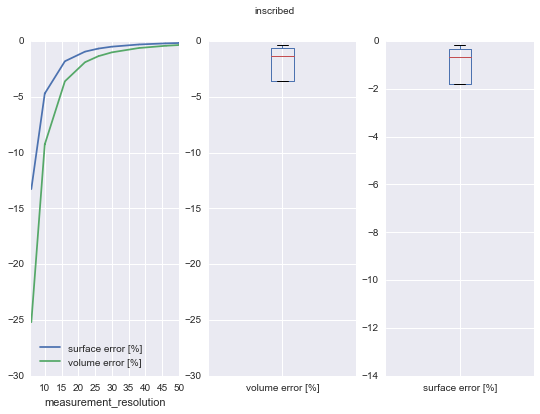

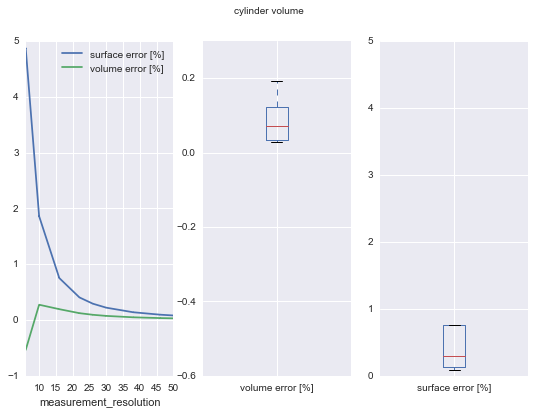

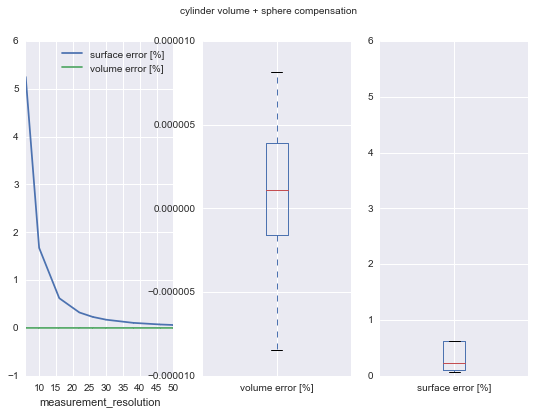

In [248]:
for radius_method in [
    "inscribed", "circumscribed", 
    "average",
    "cylinder volume", 
    "cylinder surface", 
    "cylinder volume + sphere compensation",
    "cylinder surface + sphere compensation",
]:
        
    dfs = df[
        df["output note"] == "compensation method 1 sphere " + radius_method
    ]
    dfsp = show_error(dfs)



## 3 spheres various radius

In [249]:
run_label = "compensation method 3 spheres various radius "
for radius_method in [
    "inscribed", "circumscribed", 
    "average",
    "cylinder volume", 
    "cylinder surface", 
    "cylinder volume + sphere compensation",
    "cylinder surface + sphere compensation",
]:
        
    dfs = df[
        df["output note"] == run_label + radius_method
    ]
    dfsp = show_error(dfs, x_key="radius_distribution_mean")



## 1 Cylinder

inscribed : 
surface (w/s): 
WilcoxonResult(statistic=0.0, pvalue=1.821529714896801e-05) 
SpearmanrResult(correlation=0.9690874237046978, pvalue=7.3564575879099257e-15) 
volume (w/s): 
WilcoxonResult(statistic=0.0, pvalue=1.821529714896801e-05) 
SpearmanrResult(correlation=0.9690874237046978, pvalue=7.3564575879099257e-15)
24
0
0
cylinder volume : 
surface (w/s): 
WilcoxonResult(statistic=0.0, pvalue=1.821529714896801e-05) 
SpearmanrResult(correlation=0.9690874237046978, pvalue=7.3564575879099257e-15) 
volume (w/s): 
WilcoxonResult(statistic=86.0, pvalue=0.067463836131611471) 
SpearmanrResult(correlation=0.9690874237046978, pvalue=7.3564575879099257e-15)
24
cylinder surface : 
surface (w/s): 
WilcoxonResult(statistic=0.0, pvalue=1.821529714896801e-05) 
SpearmanrResult(correlation=0.9690874237046978, pvalue=7.3564575879099257e-15) 
volume (w/s): 
WilcoxonResult(statistic=0.0, pvalue=1.821529714896801e-05) 
SpearmanrResult(correlation=0.9690874237046978, pvalue=7.3564575879099257e-15)
24

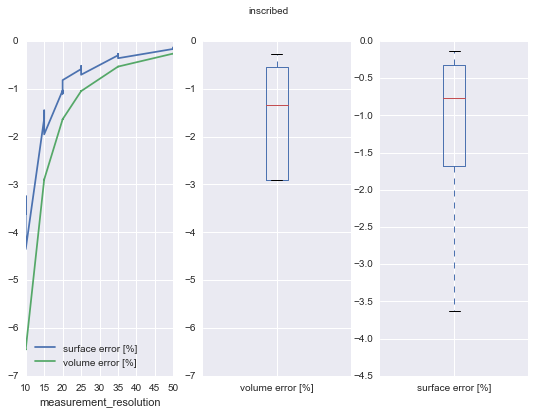

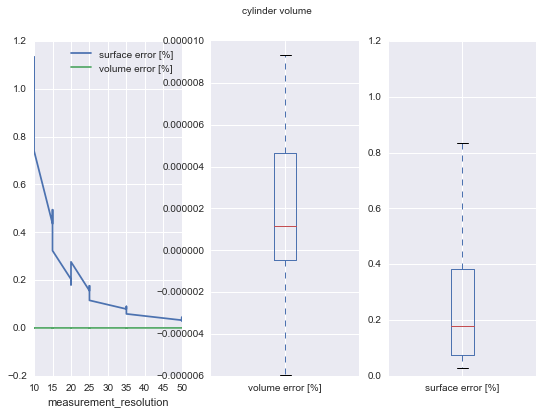

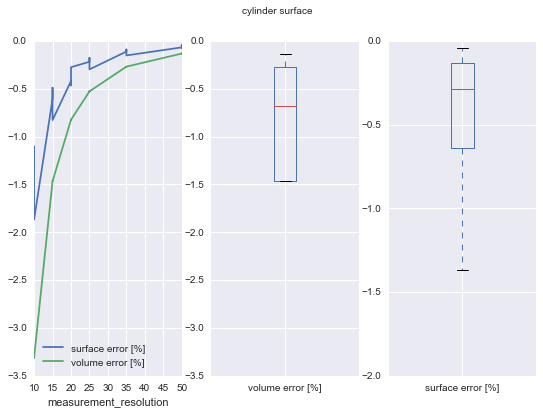

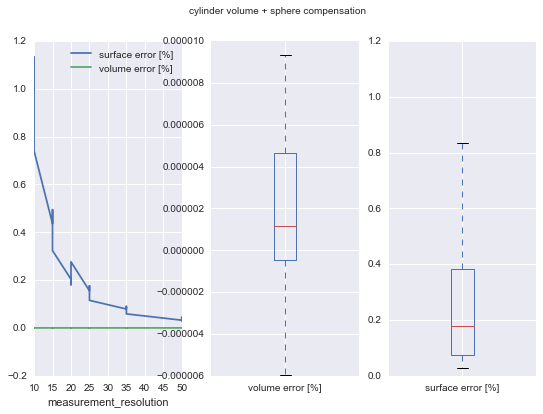

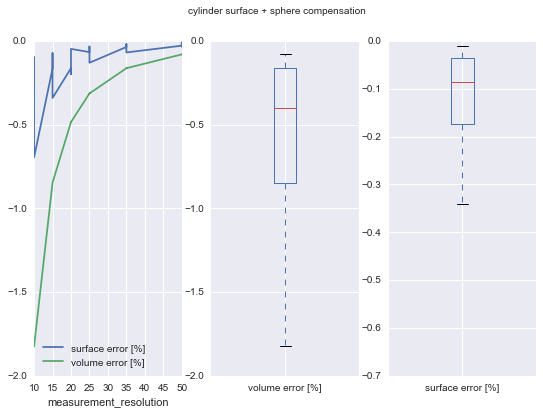

In [250]:
for radius_method in [
    "inscribed", "circumscribed", 
    "average",
    "cylinder volume", 
    "cylinder surface", 
    "cylinder volume + sphere compensation",
    "cylinder surface + sphere compensation",
]:
    dfs = df[
        df["output note"] == "compensation method 1 cylinder " + radius_method
    ]
    dfsp = show_error(dfs) #, x_key="radius_distribution_mean")
    print len(dfs)



## 1 tube

cylinder volume + sphere compensation : 
surface (w/s): 
WilcoxonResult(statistic=0.0, pvalue=1.821529714896801e-05) 
SpearmanrResult(correlation=0.9690874237046978, pvalue=7.3564575879099257e-15) 
volume (w/s): 
WilcoxonResult(statistic=28.0, pvalue=0.00049082493388360733) 
SpearmanrResult(correlation=0.9690874237046978, pvalue=7.3564575879099257e-15)
cylinder surface + sphere compensation : 
surface (w/s): 
WilcoxonResult(statistic=0.0, pvalue=1.821529714896801e-05) 
SpearmanrResult(correlation=0.9690874237046978, pvalue=7.3564575879099257e-15) 
volume (w/s): 
WilcoxonResult(statistic=0.0, pvalue=1.821529714896801e-05) 
SpearmanrResult(correlation=0.9690874237046978, pvalue=7.3564575879099257e-15)


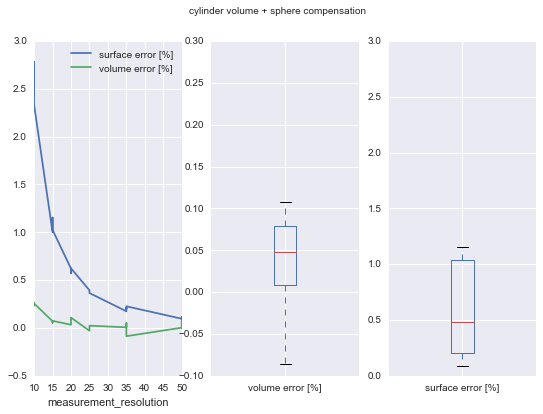

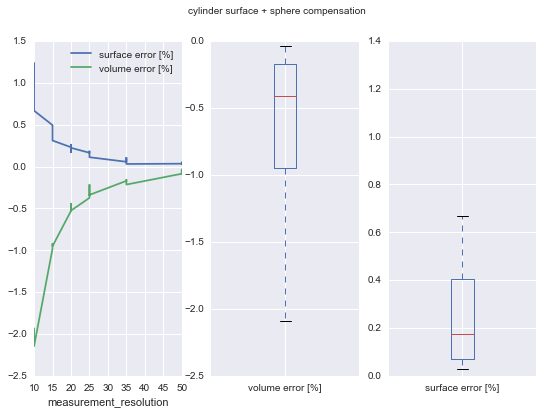

In [251]:
for radius_method in [
    "inscribed", "circumscribed", 
    "average",
    "cylinder volume", 
    "cylinder surface", 
    "cylinder volume + sphere compensation",
    "cylinder surface + sphere compensation",
]:
        
    dfs = df[
        df["output note"] == "compensation method 1 tube " + radius_method
    ]
    dfsp = show_error(dfs)



In [ ]:
radius_method
dfs = df[
    df["output note"] == "compensation method 1 tube " + radius_method
]

### 1 tube various radius

In [252]:
for radius_method in [
    "inscribed", "circumscribed", 
    "average",
    "cylinder volume", 
    "cylinder surface", 
    "cylinder volume + sphere compensation",
    "cylinder surface + sphere compensation",
]:
    dfs = df[
        df["output note"] == "compensation method 1 tube various radius " + radius_method
    ]
    dfsp = show_error(dfs, x_key="radius_distribution_mean")
    print len(dfs)



0
0
0
0
0
0
0


0
0
0
cylinder volume : 
surface (w/s): 
WilcoxonResult(statistic=0.0, pvalue=3.9958991949717481e-05) 
SpearmanrResult(correlation=0.99971715456936694, pvalue=5.9059221162991062e-34) 
volume (w/s): 
WilcoxonResult(statistic=21.0, pvalue=0.00061298434244771115) 
SpearmanrResult(correlation=0.99632252925673748, pvalue=8.0399277097918948e-23)
22
cylinder surface : 
surface (w/s): 
WilcoxonResult(statistic=28.0, pvalue=0.0013814514383582038) 
SpearmanrResult(correlation=0.99971715456936694, pvalue=5.9059221162991062e-34) 
volume (w/s): 
WilcoxonResult(statistic=1.0, pvalue=4.5966012379433768e-05) 
SpearmanrResult(correlation=0.99632252925673748, pvalue=8.0399277097918948e-23)
22
cylinder volume + sphere compensation : 
surface (w/s): 
WilcoxonResult(statistic=0.0, pvalue=3.9958991949717481e-05) 
SpearmanrResult(correlation=0.99971715456936694, pvalue=5.9059221162991062e-34) 
volume (w/s): 
WilcoxonResult(statistic=104.0, pvalue=0.46501035379406086) 
SpearmanrResult(correlation=0.9963225292

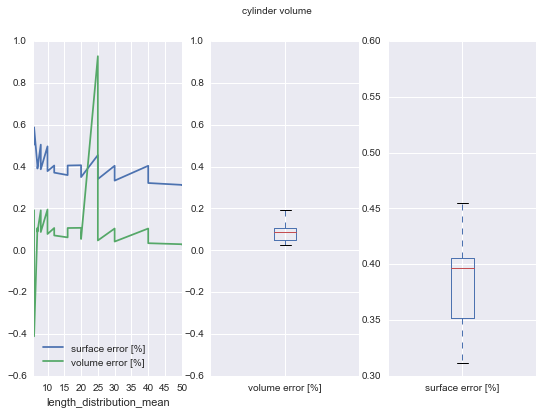

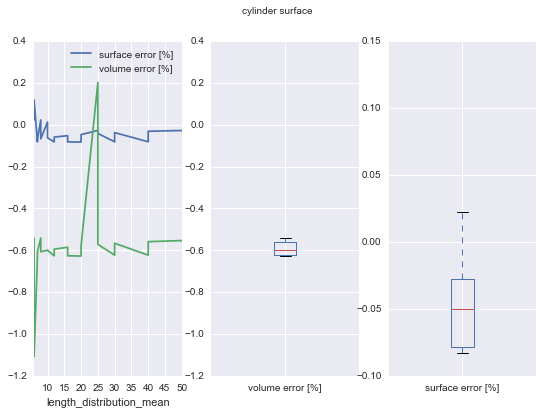

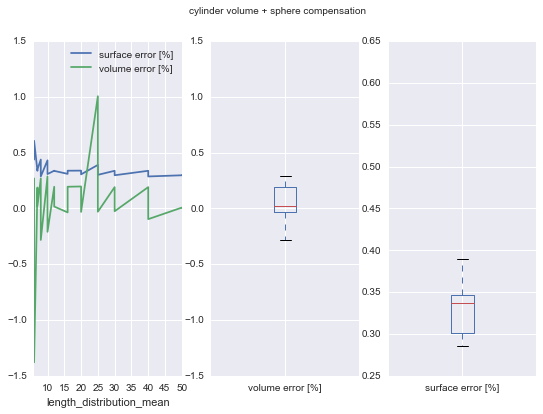

In [258]:
run_label = "compensation method 1 tube various length "
for radius_method in [
    "inscribed", "circumscribed", 
    "average",
    "cylinder volume", 
    "cylinder surface", 
    "cylinder volume + sphere compensation",
    "cylinder surface + sphere compensation",
    "best",
]:
    dfs = df[
        df["output note"] == run_label + radius_method
    ]
    dfsp = show_error(dfs, x_key="length_distribution_mean")
    print len(dfs)



cylinder volume + sphere compensation : 
surface (w/s): 
WilcoxonResult(statistic=0.0, pvalue=2.7015948487105512e-05) 
SpearmanrResult(correlation=0.96862846681241399, pvalue=3.5531602366090123e-14) 
volume (w/s): 
WilcoxonResult(statistic=15.0, pvalue=0.00018326089691585051) 
SpearmanrResult(correlation=0.96862846681241399, pvalue=3.5531602366090123e-14)
cylinder surface + sphere compensation : 
surface (w/s): 
WilcoxonResult(statistic=0.0, pvalue=2.7015948487105512e-05) 
SpearmanrResult(correlation=0.96862846681241399, pvalue=3.5531602366090123e-14) 
volume (w/s): 
WilcoxonResult(statistic=0.0, pvalue=2.7015948487105512e-05) 
SpearmanrResult(correlation=0.96862846681241399, pvalue=3.5531602366090123e-14)


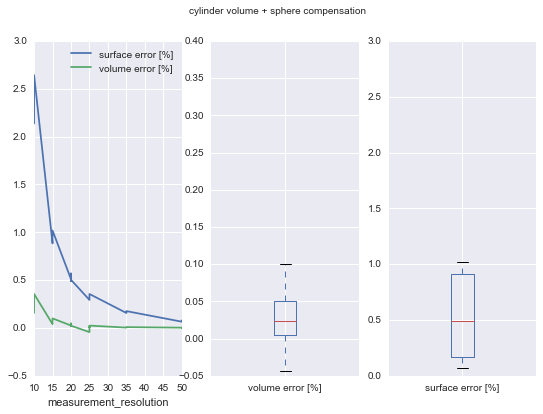

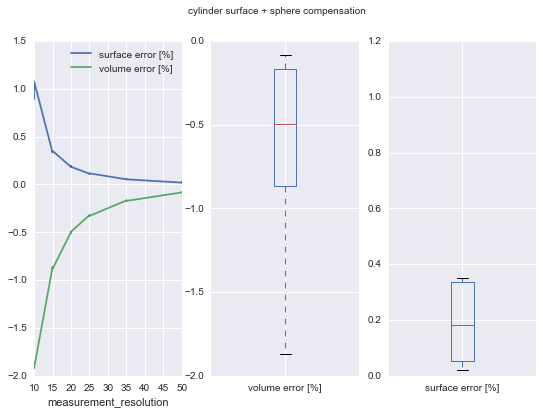

In [254]:
for radius_method in [
    "inscribed", "circumscribed", 
    "average",
    "cylinder volume", 
    "cylinder surface", 
    "cylinder volume + sphere compensation",
    "cylinder surface + sphere compensation",
    "best"
]:
        
    dfs = df[
        df["output note"] == "compensation method 1 tube mix " + radius_method
    ]
    dfsp = show_error(dfs)



## Fixed resolution

best : 
surface (w/s): 
WilcoxonResult(statistic=0.0, pvalue=0.0050620321262678644) 
SpearmanrResult(correlation=0.99999999999999989, pvalue=6.646897422032013e-64) 
volume (w/s): 
WilcoxonResult(statistic=0.0, pvalue=0.0050620321262678644) 
SpearmanrResult(correlation=0.99999999999999989, pvalue=6.646897422032013e-64)


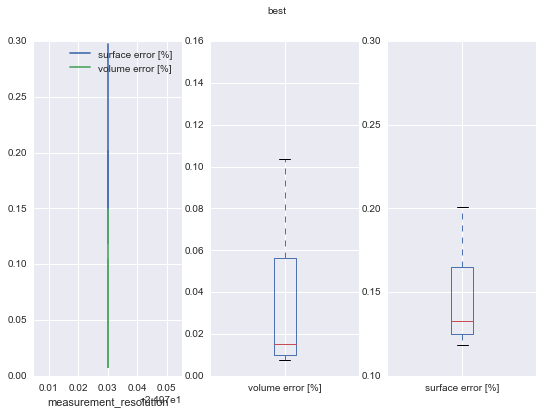

In [255]:

for radius_method in [
    "inscribed", "circumscribed", 
    "average",
    "cylinder volume", 
    "cylinder surface", 
    "cylinder volume + sphere compensation",
    "cylinder surface + sphere compensation",
    "best",
]:
        
    dfs = df[
        df["output note"] == "fixed resolution " + radius_method
    ]
    dfsp = show_error(dfs)



# Best test

best : 
surface (w/s): 
WilcoxonResult(statistic=0.0, pvalue=0.0014737808438751421) 
SpearmanrResult(correlation=0.98058067569092, pvalue=3.946593148302076e-09) 
volume (w/s): 
WilcoxonResult(statistic=0.0, pvalue=0.0014737808438751421) 
SpearmanrResult(correlation=0.98058067569092, pvalue=3.946593148302076e-09)


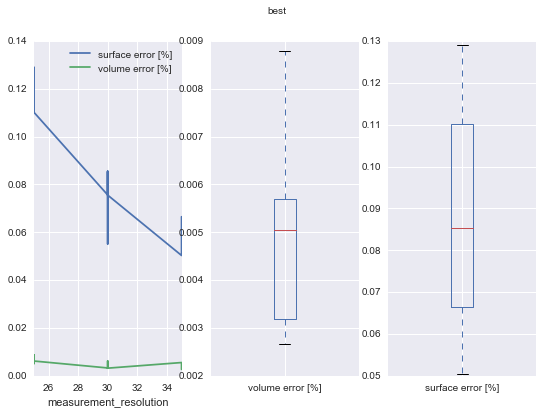

In [256]:

for radius_method in [
    "inscribed", "circumscribed", 
    "average",
    "cylinder volume", 
    "cylinder surface", 
    "cylinder volume + sphere compensation",
    "cylinder surface + sphere compensation",
    "best",
]:
        
    dfs = df[
        df["output note"] == "best test " + radius_method
    ]
    dfsp = show_error(dfs)



# Simple check - this computes selected radius from data

/Users/mjirik/miniconda/lib/python2.7/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


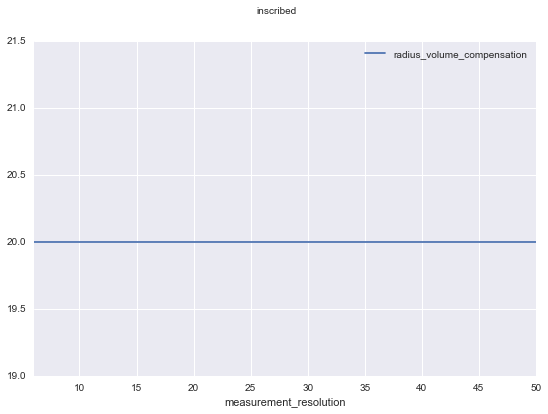

In [257]:
# just for control - this should be exactly same as selected radius
radius_method = "inscribed"
dfs = df[
    df["output note"] == "compensation method 1 sphere " + radius_method
    # df["generators Unconnected cylinders radius_distribution_mean"] == 5 
]

if len(dfs) > 1:
    dfs["radius_volume_compensation"] = (3 * dfs["volume [mm^3]"] / (4* np.pi))**(1.0/3.0)
    dfsp = dfs[["radius_volume_compensation", "measurement_resolution"]].sort_values(
        "measurement_resolution")

    fig = plt.figure(figsize=[25, 18])
    ax = plt.subplot(111)
    dfsp.plot(
        ax=ax, x="measurement_resolution", **plotkw)
    plt.suptitle(radius_method)